# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


The data has already been cleaned, so there are no missing values

In [3]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [4]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [6]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough"))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [7]:
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=15, random_state=42)

## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [8]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9826666666666667
Test accuracy: 0.913


In [9]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7312  177]
 [  83 7428]]
Test confusion matrix:
[[2293  218]
 [ 217 2272]]


## Business Interpretation

The tuned Random Forest Classifier model appears to be somewhat overfit on the training data, but nevertheless achieves 91% accuracy on the test data.  Of the 9% of mislabeled comments, about half are false positives and half are false negatives.

Because this is a balanced dataset, 91% accuracy is a substantial improvement over a 50% baseline.  This model is ready for production use for decision support.

In [13]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

#Instantiate a StandardScaler object
ss = StandardScaler()
#Generate a new X_train_transformed_scaled by calling .fit_transform on the scaler object,
#after you have called .fit_transform on the pipeline
X_train_transformed_scaled = ss.fit_transform(X_train_transformed)
#Generate a new X_test_transformed_scaled by calling .transform on the scaler object,
#after you have called .transform on the pipeline
X_test_transformed_scaled = ss.transform(X_test_transformed)

In [32]:
#Instantiate a Sequential model
model = Sequential()
#Add an input Dense layer. You'll need to specify a input_shape = (11275,) 
#because this is the number of features of the transformed dataset.
model.add(Dense(units=64, activation="relu", input_shape=(11275,)))
#Add 2 Dense hidden layers. They can have any number of units, but keep in mind that more units will require more processing power. 
#We recommend an initial units of 64 for processing power reasons.
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=64, activation="relu"))
#Add a final Dense output layer. This layer must have exactly 1 unit because we are doing a binary prediction task.
model.add(Dense(1, activation="sigmoid"))
#Compile the Sequential model
model.compile(optimizer="adam", loss= "binary_crossentropy", metrics=["Accuracy"])
#Fit the Sequential model on the preprocessed training data (X_train_transformed_scaled) 
#with a bbatch_size of 50 and epochs of 5 for processing power reasons.
model.fit(X_train_transformed_scaled, y_train, batch_size=50, epochs=5)

Epoch 1/5
300/300 [==============================] - 3s 9ms/step - loss: 0.3040 - accuracy: 0.0000e+00
Epoch 2/5
300/300 [==============================] - 3s 11ms/step - loss: 0.0325 - accuracy: 0.0073
Epoch 3/5
300/300 [==============================] - 2s 8ms/step - loss: 0.0063 - accuracy: 0.0572
Epoch 4/5
300/300 [==============================] - 2s 8ms/step - loss: 0.0032 - accuracy: 0.1386
Epoch 5/5
300/300 [==============================] - 3s 11ms/step - loss: 5.5151e-04 - accuracy: 0.1761


3) Model Tuning + Feature Engineering
If you are running out of time, skip this step.

Tune the neural network model to improve performance. This could include steps such as increasing the units, changing the activation functions, or adding regularization.

We recommend using using a validation_split of 0.1 to understand model performance without utilizing the test holdout set.

You can also return to the preprocessing phase, and add additional features to the model.

In [34]:
#Instantiate a Sequential model
model2 = Sequential()
#Add an input Dense layer. You'll need to specify a input_shape = (11275,) 
model2.add(Dense(units=64, activation="relu", input_shape=(11275,)))
#Add 2 Dense hidden layers. They can have any number of units, but keep in mind that more units will require more processing power. 
#We recommend an initial units of 64 for processing power reasons.
model2.add(Dense(units=128, activation="relu"))
model2.add(Dense(units=128, activation="relu"))
#Add a final Dense output layer. This layer must have exactly 1 unit because we are doing a binary prediction task.
model2.add(Dense(1, activation="sigmoid"))
#Compile the Sequential model
model2.compile(optimizer="adam", loss= "binary_crossentropy", metrics=["Accuracy"])
#Fit the Sequential model on the preprocessed training data (X_train_transformed_scaled) 
#with a bbatch_size of 50 and epochs of 5 for processing power reasons.
model2.fit(X_train_transformed_scaled, y_train, batch_size=50, epochs=20)

Epoch 1/20
300/300 [==============================] - 3s 10ms/step - loss: 0.3023 - accuracy: 0.0000e+00
Epoch 2/20
300/300 [==============================] - 3s 9ms/step - loss: 0.0318 - accuracy: 0.0110
Epoch 3/20
300/300 [==============================] - 3s 10ms/step - loss: 0.0074 - accuracy: 0.0959
Epoch 4/20
300/300 [==============================] - 3s 8ms/step - loss: 0.0016 - accuracy: 0.2241
Epoch 5/20
300/300 [==============================] - 2s 8ms/step - loss: 2.0990e-04 - accuracy: 0.2911
Epoch 6/20
300/300 [==============================] - 2s 8ms/step - loss: 7.3602e-05 - accuracy: 0.3179
Epoch 7/20
300/300 [==============================] - 3s 9ms/step - loss: 4.2280e-04 - accuracy: 0.3275
Epoch 8/20
300/300 [==============================] - 2s 8ms/step - loss: 4.5728e-04 - accuracy: 0.3772
Epoch 9/20
300/300 [==============================] - 3s 9ms/step - loss: 6.1975e-04 - accuracy: 0.3727
Epoch 10/20
300/300 [==============================] - 4s 15ms/step - loss

In [41]:
64*4

256

In [44]:
#Instantiate a Sequential model
model3 = Sequential()
#Add an input Dense layer. You'll need to specify a input_shape = (11275,) 
#because this is the number of features of the transformed dataset.
model3.add(Dense(units=64, activation="relu", input_shape=(11275,)))
#Add Dense hidden layers.
model3.add(Dense(units=128, activation="relu", kernel_regularizer=regularizers.l1(0.0001)))
model3.add(Dense(units=128, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
model3.add(Dense(units=64, activation="relu"))
#Add a final Dense output layer. This layer must have exactly 1 unit because we are doing a binary prediction task.
model3.add(Dense(1, activation="sigmoid"))
#Compile the Sequential model
model3.compile(optimizer="adam", loss= "binary_crossentropy", metrics=["Accuracy"])
#Fit the Sequential model on the preprocessed training data (X_train_transformed_scaled) 
model.fit(X_train_transformed_scaled, y_train, batch_size=50, epochs=25)

Epoch 1/25
300/300 [==============================] - 4s 13ms/step - loss: 0.3849 - accuracy: 0.0000e+00
Epoch 2/25
300/300 [==============================] - 4s 12ms/step - loss: 0.1028 - accuracy: 0.0206
Epoch 3/25
300/300 [==============================] - 3s 11ms/step - loss: 0.0658 - accuracy: 0.1128
Epoch 4/25
300/300 [==============================] - 3s 11ms/step - loss: 0.0469 - accuracy: 0.1573
Epoch 5/25
300/300 [==============================] - 3s 11ms/step - loss: 0.0328 - accuracy: 0.2238
Epoch 6/25
300/300 [==============================] - 3s 9ms/step - loss: 0.0227 - accuracy: 0.2382
Epoch 7/25
300/300 [==============================] - 2s 8ms/step - loss: 0.0158 - accuracy: 0.2199
Epoch 8/25
300/300 [==============================] - 2s 8ms/step - loss: 0.0110 - accuracy: 0.1895
Epoch 9/25
300/300 [==============================] - 2s 8ms/step - loss: 0.0076 - accuracy: 0.1586
Epoch 10/25
300/300 [==============================] - 3s 9ms/step - loss: 0.0053 - accurac

In [46]:
#Instantiate a Sequential model
model4 = Sequential()
#Add an input Dense layer. You'll need to specify a input_shape = (11275,) 
model4.add(Dense(units=64, activation="relu", input_shape=(11275,)))
#Add Dense hidden layers.
model4.add(Dense(units=128, activation="relu"))
model4.add(Dense(units=256, activation="relu"))
model4.add(Dropout(0.025))
model4.add(Dense(units=16, activation="relu"))
#Add a final Dense output layer. This layer must have exactly 1 unit because we are doing a binary prediction task.
model4.add(Dense(1, activation="sigmoid"))
#Compile the Sequential model
model4.compile(optimizer="adam", loss= "binary_crossentropy", metrics=["Accuracy"])
#Fit the Sequential model on the preprocessed training data (X_train_transformed_scaled) 
model4.fit(X_train_transformed_scaled, y_train, batch_size=50, epochs=25)

Epoch 1/25
300/300 [==============================] - 5s 17ms/step - loss: 0.2993 - accuracy: 0.0000e+00
Epoch 2/25
300/300 [==============================] - 4s 13ms/step - loss: 0.0336 - accuracy: 0.0082
Epoch 3/25
300/300 [==============================] - 3s 11ms/step - loss: 0.0074 - accuracy: 0.0838
Epoch 4/25
300/300 [==============================] - 3s 10ms/step - loss: 0.0030 - accuracy: 0.1888
Epoch 5/25
300/300 [==============================] - 3s 11ms/step - loss: 0.0011 - accuracy: 0.2401
Epoch 6/25
300/300 [==============================] - 3s 11ms/step - loss: 5.2429e-04 - accuracy: 0.3025
Epoch 7/25
300/300 [==============================] - 4s 13ms/step - loss: 0.0013 - accuracy: 0.2797
Epoch 8/25
300/300 [==============================] - 4s 13ms/step - loss: 8.3579e-05 - accuracy: 0.3473
Epoch 9/25
300/300 [==============================] - 4s 13ms/step - loss: 4.9873e-05 - accuracy: 0.3853
Epoch 10/25
300/300 [==============================] - 3s 11ms/step - loss:

4) Model Evaluation

Choose a final Sequential model, add layers, and compile. Fit the model on the preprocessed training data (X_train_transformed_scaled, y_train) and evaluate on the preprocessed testing data (X_test_transformed_scaled, y_test) using accuracy_score.

In [48]:
#Our best model was model number 4 (model4) as seen bellow.

#Instantiate a Sequential model
model4 = Sequential()
#Add an input Dense layer. You'll need to specify a input_shape = (11275,) 
model4.add(Dense(units=64, activation="relu", input_shape=(11275,)))
#Add Dense hidden layers.
model4.add(Dense(units=128, activation="relu"))
model4.add(Dense(units=256, activation="relu"))
model4.add(Dropout(0.025))
model4.add(Dense(units=16, activation="relu"))
#Add a final Dense output layer. This layer must have exactly 1 unit because we are doing a binary prediction task.
model4.add(Dense(1, activation="sigmoid"))
#Compile the Sequential model
model4.compile(optimizer="adam", loss= "binary_crossentropy", metrics=["Accuracy"])
#Fit the Sequential model on the preprocessed training data (X_train_transformed_scaled) 
model_data = model4.fit(X_train_transformed_scaled, y_train, batch_size=50, epochs=25)

Epoch 1/25
300/300 [==============================] - 6s 19ms/step - loss: 0.3017 - accuracy: 0.0000e+00
Epoch 2/25
300/300 [==============================] - 6s 19ms/step - loss: 0.0347 - accuracy: 0.0251
Epoch 3/25
300/300 [==============================] - 3s 10ms/step - loss: 0.0077 - accuracy: 0.1159
Epoch 4/25
300/300 [==============================] - 3s 12ms/step - loss: 0.0037 - accuracy: 0.2119
Epoch 5/25
300/300 [==============================] - 3s 11ms/step - loss: 0.0011 - accuracy: 0.2677
Epoch 6/25
300/300 [==============================] - 4s 13ms/step - loss: 6.1089e-04 - accuracy: 0.3644
Epoch 7/25
300/300 [==============================] - 4s 14ms/step - loss: 0.0010 - accuracy: 0.3363
Epoch 8/25
300/300 [==============================] - 3s 9ms/step - loss: 4.4987e-05 - accuracy: 0.2843
Epoch 9/25
300/300 [==============================] - 4s 13ms/step - loss: 1.6354e-05 - accuracy: 0.3361
Epoch 10/25
300/300 [==============================] - 4s 13ms/step - loss: 

In [51]:
#Print the loss and accuracy for the training set 
results_train = model4.evaluate(X_train_transformed_scaled, y_train)
results_train

469/469 [==============================] - 2s 5ms/step - loss: 2.0787e-07 - accuracy: 0.4661


[2.0786725940524775e-07, 0.4660666584968567]

In [52]:
#Print the loss and accuracy for the test set 
results_test = model4.evaluate(X_test_transformed_scaled, y_test)
results_test

157/157 [==============================] - 1s 5ms/step - loss: 0.8253 - accuracy: 0.3216


[0.825266420841217, 0.3215999901294708]

In [54]:
model_dict = model_data.history
model_dict.keys()

dict_keys(['loss', 'accuracy'])

5) Technical Communication

Write a paragraph explaining whether Northwind Trading Company should switch to using your new neural network model, or continue to use the Random Forest Classifier. Beyond a simple comparison of performance, try to take into consideration additional considerations such as:

Computational complexity/resource use

Anticipated performance on future datasets (how might the data change over time?)

Types of mistakes made by the two kinds of models


You can make guesses or inferences about these considerations.
Include at least one visualization comparing the two types of models. Possible points of comparison could include ROC curves, colorized confusion matrices, or time needed to train.

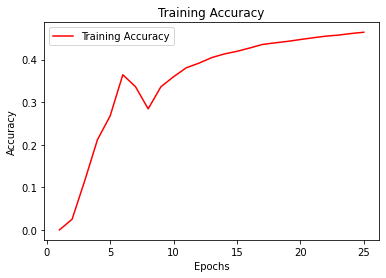

In [61]:
acc_values = model_dict['accuracy'] 
epochs = range(1, len(model_dict['loss']) + 1)

plt.plot(epochs, acc_values, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From what I have been able to work on I would recommend to keep using the Random Forest Model for now. While it is overfitting we can adjust some hyperparameters to adjust this.

However I would continue to invest in a Machine Learning model. While our final model scored right under random chance, our model was still improving. We only spent an hour looking at different parameters, if given more time we could improve our score greatly. We can see proof of this in our Training Accuracy graph above. We can see that our best model was still improving and had not flattened out yet. Given more time I would also like to see what was causing the spike at the 6 epoch level. 

I am confident that given more time, we could build a model that does not overfit like the random forest and therefore performs better on different datasets that have a similar theme of recommending a product or not.